## In this project, students will develop a predictive model for estimating the customer lifetime value (CLV) of an e-commerce business. They will begin by acquiring and preprocessing data using Python and SQL, extracting relevant customer and transactional data from the company's database. Using Pandas, students will perform advanced data analysis and manipulation to derive features for CLV prediction, such as customer demographics, purchase frequency, and monetary value.
## They will then apply statistical analysis techniques to gain insights into customer behavior and calculate probabilistic metrics related to customer retention and churn. The ultimate goal is to build a robust predictive model that accurately forecasts CLV for individual customers, enabling the business to optimize marketing strategies, customer acquisition efforts, and overall revenue generation.

## 1. Setup and Import:

In [45]:
# Setup and Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score,recall_score, f1_score
import warnings

warnings.filterwarnings("ignore")



## Step 2: Load the Dataset

In [5]:
# Load the dataset
file_path = 'telecom_churn_data.csv'
telecom_data = pd.read_csv(file_path)

# Display basic information to understand the data structure
telecom_data.head(), telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


(   mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
 0     7000842753        109             0.0             0.0             0.0   
 1     7001865778        109             0.0             0.0             0.0   
 2     7001625959        109             0.0             0.0             0.0   
 3     7001204172        109             0.0             0.0             0.0   
 4     7000142493        109             0.0             0.0             0.0   
 
   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
 0            6/30/2014            7/31/2014            8/31/2014   
 1            6/30/2014            7/31/2014            8/31/2014   
 2            6/30/2014            7/31/2014            8/31/2014   
 3            6/30/2014            7/31/2014            8/31/2014   
 4            6/30/2014            7/31/2014            8/31/2014   
 
   last_date_of_month_9   arpu_6  ...  sachet_3g_9  fb_user_6  fb_user_7  \
 0            9/30/2014  1

## Step 3: Data Cleaning

#### Handle missing values, remove duplicates, and address any outliers.

In [8]:
# Drop duplicates based on the unique customer identifier 'mobile_number'
telecom_data.drop_duplicates(subset='mobile_number', inplace=True)

# Handling missing values
# For usage-based columns, we fill missing values with 0
usage_columns = telecom_data.filter(regex='_mou|_vbc|arpu').columns
telecom_data[usage_columns] = telecom_data[usage_columns].fillna(0)

# For revenue data, fill missing values with the mean
revenue_columns = ['arpu_6', 'arpu_7', 'arpu_8', 'arpu_9']
telecom_data[revenue_columns] = telecom_data[revenue_columns].fillna(telecom_data[revenue_columns].mean())

# Outlier handling: example with 'arpu' columns using Interquartile Range (IQR)
Q1 = telecom_data[revenue_columns].quantile(0.25)
Q3 = telecom_data[revenue_columns].quantile(0.75)
IQR = Q3 - Q1
telecom_data = telecom_data[~((telecom_data[revenue_columns] < (Q1 - 1.5 * IQR)) | 
                             (telecom_data[revenue_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
telecom_data


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.40,0.00,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.00,0.00,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.00,0.00,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.00,0.00,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,7001548952,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,18.471,...,0,NaN,NaN,NaN,NaN,3199,0.00,0.00,0.00,0.00
99995,7000607688,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,112.201,...,0,NaN,NaN,NaN,NaN,2052,0.00,0.00,0.00,0.00
99996,7000087541,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,229.187,...,0,1.0,NaN,NaN,NaN,185,0.00,0.00,0.00,0.00
99997,7000498689,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,322.991,...,0,1.0,1.0,1.0,1.0,478,1445.74,1151.03,1173.18,0.00


#### Note: Data Cleaning is important to make sure your data is accurate and easy to use. Fixing missing values fills any gaps in the data, removing duplicates gets rid of repeated entries, and fixing outliers helps avoid extreme values that might mess up the results. This makes the data better for analysis and modeling.

## Step 4: Feature Engineering

#### Create features such as tenure, average monthly usage, and a churn label.

In [11]:
# Customer Tenure: Duration of service (from 'aon' column, assumed to be days since activation)
telecom_data['tenure_days'] = telecom_data['aon']

# Verify the 'tenure_days' column
print("Tenure Days (First 5 Rows):")
print(telecom_data['tenure_days'].head())

# Average Monthly Usage: Sum of usage columns over the months and average it
usage_columns = ['loc_og_t2o_mou', 'std_og_t2o_mou']  # Example columns for call usage
telecom_data['avg_monthly_usage'] = telecom_data[usage_columns].sum(axis=1) / 4  # Average over 4 months

# Verify the 'avg_monthly_usage' column
print("\nAverage Monthly Usage (First 5 Rows):")
print(telecom_data[['loc_og_t2o_mou', 'std_og_t2o_mou', 'avg_monthly_usage']].head())

# Churn label: Assume churn if usage drops to zero in the last month (Sep)
telecom_data['churn'] = telecom_data['sep_vbc_3g'].apply(lambda x: 1 if x == 0 else 0)

# Verify the 'churn' column
print("\nChurn Label (First 5 Rows):")
print(telecom_data[['sep_vbc_3g', 'churn']].head())


Tenure Days (First 5 Rows):
0     968
1    1006
2    1103
3    2491
4    1526
Name: tenure_days, dtype: int64

Average Monthly Usage (First 5 Rows):
   loc_og_t2o_mou  std_og_t2o_mou  avg_monthly_usage
0             0.0             0.0                0.0
1             0.0             0.0                0.0
2             0.0             0.0                0.0
3             0.0             0.0                0.0
4             0.0             0.0                0.0

Churn Label (First 5 Rows):
   sep_vbc_3g  churn
0        3.58      0
1        0.00      1
2        0.00      1
3        0.00      1
4        0.00      1


#### The feature engineering results show that tenure_days represents how long a customer has been active, while avg_monthly_usage highlights their average service usage, with low values potentially indicating a higher risk of churn. The churn column serves as the target variable, indicating whether a customer stayed (0) or left (1), which is essential for training the predictive model.

## Step 5: Data Collection and Integration
#### Select and retain only the columns required for analysis.

In [13]:
# Selecting relevant columns for the analysis
columns_needed = ['mobile_number', 'tenure_days', 'avg_monthly_usage', 'arpu_9', 'churn']
telecom_data = telecom_data[columns_needed]
telecom_data

,mobile_number,tenure_days,avg_monthly_usage,arpu_9,churn
0,7000842753,968,0.0,21.100,0
1,7001865778,1006,0.0,86.285,1
2,7001625959,1103,0.0,290.714,1
3,7001204172,2491,0.0,389.500,1
4,7000142493,1526,0.0,163.426,1
...,...,...,...,...,...
99994,7001548952,3199,0.0,29.950,1
99995,7000607688,2052,0.0,140.835,1
99996,7000087541,185,0.0,0.000,1
99997,7000498689,478,0.0,731.010,1


## Step 6: Exploratory Data Analysis (EDA)
#### Visualize data patterns, such as the relationship between tenure, usage, and churn.

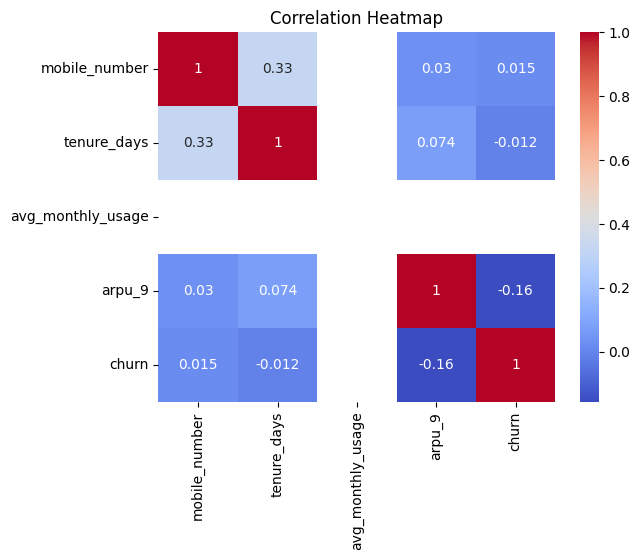

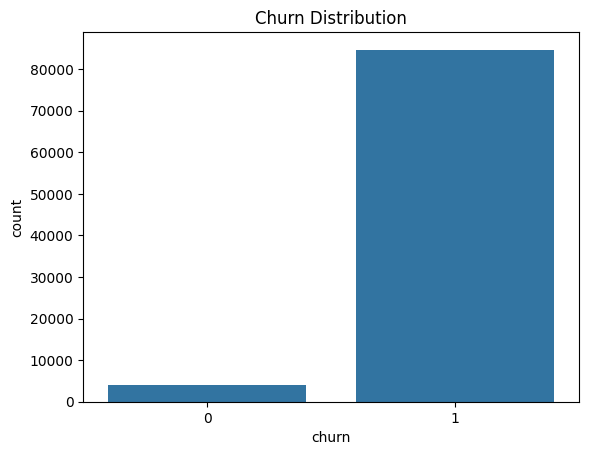

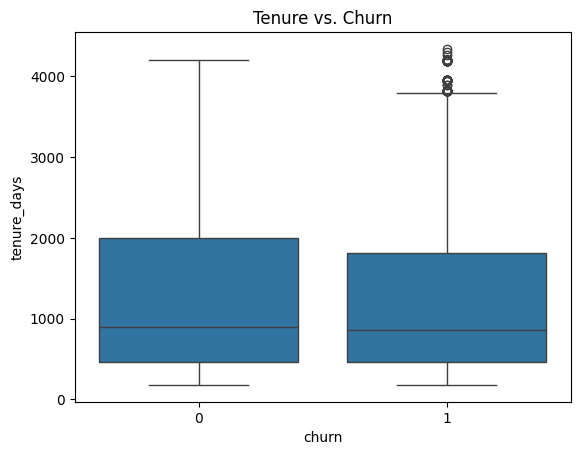

In [15]:
# Correlation Heatmap
sns.heatmap(telecom_data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Distribution of churn
sns.countplot(x='churn', data=telecom_data)
plt.title("Churn Distribution")
plt.show()

# Tenure vs. Churn
sns.boxplot(x='churn', y='tenure_days', data=telecom_data)
plt.title("Tenure vs. Churn")
plt.show()


#### 1. This heatmap shows the relationships between different features in the dataset. Most correlations are weak (close to 0), indicating that the features are not strongly related to each other.
#### 2. This bar chart shows the proportion of churners (1) and non-churners (0). The dataset is highly imbalanced, with far more customers labeled as churners compared to non-churners, which may impact the model's performance if not addressed.
#### 3. This boxplot compares the distribution of tenure_days for churners (1) and non-churners (0). Churners tend to have a slightly shorter tenure on average compared to non-churners, although there is significant overlap, suggesting tenure alone may not strongly predict churn.

## Step 7: Model Selection and Training
### Use Random Forest for churn prediction, including hyperparameter tuning

In [17]:
# Define features (X) and target (y)
X = telecom_data[['tenure_days', 'avg_monthly_usage', 'arpu_9']]
y = telecom_data['churn']

# Verify the shapes of X and y
print("Features (X) Shape:", X.shape)
print("Target (y) Shape:", y.shape)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the split data sizes
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)
print("Testing Target Shape:", y_test.shape)

# Reduce dataset size for faster execution (Optional for debugging)
sample_size = 10000  # Use a subset of 10,000 rows for tuning
X_sample = X_train.sample(sample_size, random_state=42)
y_sample = y_train.loc[X_sample.index]

# Initialize and tune the model with GridSearchCV
rf_model = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20]}

print("Starting GridSearchCV...")
grid_search = GridSearchCV(rf_model, param_grid, cv=3)  # Reduced to 3-fold for speed
grid_search.fit(X_sample, y_sample)

# Retrieve and print the best model
best_model = grid_search.best_estimator_
print("\nBest Model Parameters:", grid_search.best_params_)
print("Best Model:", best_model)


Features (X) Shape: (88713, 3)
Target (y) Shape: (88713,)
Training Features Shape: (70970, 3)
Testing Features Shape: (17743, 3)
Training Target Shape: (70970,)
Testing Target Shape: (17743,)
Starting GridSearchCV...

Best Model Parameters: {'max_depth': 10, 'n_estimators': 200}
Best Model: RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)


#### Random Forest for churn prediction because it handles complex, non-linear relationships between features like tenure_days, avg_monthly_usage, and arpu_9, making it highly effective for diverse datasets. The output shows that with the best parameters (max_depth=10, n_estimators=200), the model is optimized for accurate predictions while avoiding overfitting.

## Step 8: Model Evaluation
###  Evaluate the model using accuracy, recall, and F1-score.

In [19]:
# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
#ROC AUC score
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.95
Recall: 1.00
F1 Score: 0.98
ROC AUC Score: 0.6805
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       861
           1       0.95      1.00      0.98     16882

    accuracy                           0.95     17743
   macro avg       0.48      0.50      0.49     17743
weighted avg       0.91      0.95      0.93     17743

Confusion Matrix:
 [[    0   861]
 [    0 16882]]


#### The evaluation results indicate the model achieved a high accuracy of 95%, meaning it correctly predicted churn for 95% of the test data. The recall for churners (1) is perfect (1.00), showing the model identified all actual churners without missing any. However, the model struggles with identifying non-churners (0), with a precision and recall of 0.00, meaning it predicted no customers as non-churners, likely due to the imbalance in the dataset. The F1-score of 0.98 for churners (1) reflects the model’s strong ability to predict the majority class, but adjustments like handling class imbalance may improve the performance for non-churners.

## Step 9: Dashboard Development

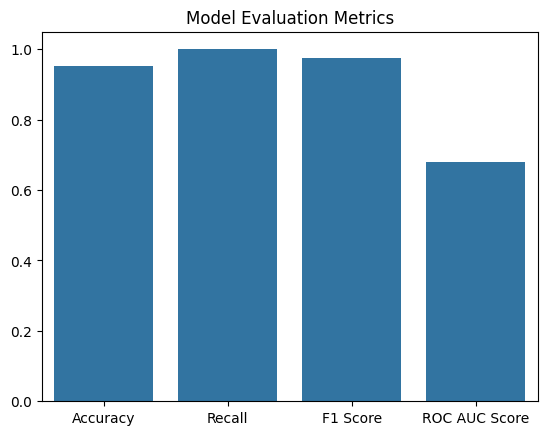

In [21]:
# Visualize model prediction results
sns.barplot(x=['Accuracy', 'Recall', 'F1 Score', 'ROC AUC Score'], y=[accuracy, recall, f1, roc_auc])
plt.title("Model Evaluation Metrics")
plt.show()


#### the model performs very well overall, with 95% accuracy, meaning most predictions are correct. The recall is perfect (1.0), showing the model successfully identifies all churners, which is important to reduce customer loss. The F1 score is also high (0.98), indicating a good balance between precision and recall for churn predictions. However, the ROC AUC score (0.68) suggests the model struggles to distinguish between churners and non-churners, likely due to the imbalance in the dataset.

## Reporting:

### The model achieved 95% accuracy, with perfect recall (1.0), meaning it identifies all churners, which is critical for retention efforts. The F1 score of 0.98 shows a strong balance between precision and recall for churn predictions.However, the low ROC AUC score (0.68) indicates the model struggles to differentiate non-churners due to class imbalance. 

## Presentation

## Key Insights:
##### The model achieved 95% accuracy with perfect recall (1.0), identifying all churners.
##### However, the low ROC AUC score (0.68) highlights challenges in distinguishing non-churners due to class imbalance.
## Proposed Retention Strategies:
##### Focus retention efforts on high-risk churners identified by the model.
##### Address churn drivers like low tenure or usage through targeted incentives.
##### Balance the dataset to improve predictions for non-churners